In [25]:
from distmesh import *
from FEM_TPT import *
from FEM_TPT import trajectory_probability_density
import numpy as np
import math
import matplotlib.pyplot as plt
import csv 

ImportError: cannot import name 'trajectory_probability_density' from 'FEM_TPT' (/Users/williamclark/Documents/1mathematics/UMD_reu/transition_path_theory_FEM_distmesh/FEM_TPT.py)

In [ ]:
# finds the committor, the reactive current, and the reaction rate for the face potential 
# using the finite element method and the distmesh triangulation

# the committor equation 

# \nabla \cdot (\exp( - \beta fpot(x) \nabla q(x) ) = 0, x \in (A\cup B)^c
# q(\partial A) = 0, q(\partial B) = 1
# dq/dn = 0, x \in outer boundaty defined by {x : fpot(x) = Vbdry}

# the homogeneous Neumann boundary condition dq/dn = 0 means that 
# the trajectory reflects from the outer boundary whenever it reaches it

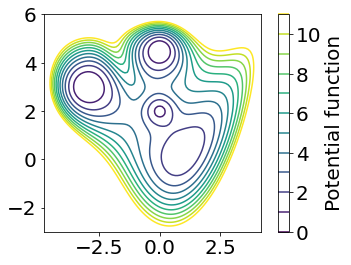

In [ ]:
# parameters for the face potential
xa=-3 
ya=3
xb=0 
yb=4.5
par = np.array([xa,ya,xb,yb]) # centers of sets A and B

# problem setup: choose sets A and B and the outer boundary
# set A is the circle with center at (xa,ya) and radius ra
# set B is the circle with center at (xb,yb) and radius rb
ra = 0.5 # radius of set A
rb = 0.5 # radius of set B
beta = 3 # beta = 1/(k_B T), T = temperature, k_B = Boltzmann's constant
Vbdry = 12 # level set of the outer boundary {x : fpot(x) = Vbdry}

# if generate_mesh = True, mesh is generated and saves as csv files
# if generate_mesh = False, mesh is downloaded from those csv files
generate_mesh = False

# h0 is the desired scalind parameter for the mesh
h0 = 0.1


def face(xy,par):
    xa=par[0]
    ya=par[1]
    xb=par[2] 
    yb=par[3]
    x = xy[:,0]
    y = xy[:,1]
    f=(1-x)**2+(y-0.25*x**2)**2+1
    g1=1-np.exp(-0.125*((x-xa)**2+(y-ya)**2))
    g2=1-np.exp(-0.25*(((x-xb)**2+(y-yb)**2)))
    g3=1.2-np.exp(-2*((x+0)**2+(y-2)**2))
    g4=1+np.exp(-2*(x+1.5)**2-(y-3.5)**2-(x+1)*(y-3.5))
    v = f*g1*g2*g3*g4
    return v

# define face potential on a meshgrid
nx,ny= (100,100)
nxy = nx*ny
xmin = -4.8
xmax = 4.2
ymin = -3
ymax = 6
x1 = np.linspace(xmin,xmax,nx)
y1 = np.linspace(ymin,ymax,ny)
x_grid, y_grid = np.meshgrid(x1,y1)
x_vec = np.reshape(x_grid, (nxy,1))
y_vec = np.reshape(y_grid, (nxy,1))
v = np.zeros(nxy)
xy = np.concatenate((x_vec,y_vec),axis=1)
v = face(xy,par)
vmin = np.amin(v)
v_grid = np.reshape(v,(nx,ny))    
# graphics
plt.rcParams.update({'font.size': 20})
ls = plt.contour(x_grid,y_grid,v_grid,np.arange(0,Vbdry,1))
plt.colorbar(label="Potential function", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)


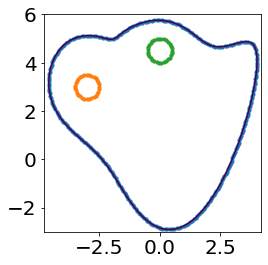

In [ ]:
# set sets A and B and the outer boundary
Na = int(round(2*math.pi*ra/h0))
Nb = int(round(2*math.pi*rb/h0))
ptsA = put_pts_on_circle(xa,ya,ra,Na)
ptsB = put_pts_on_circle(xb,yb,rb,Nb)

# outer boundary
bdrydata = plt.contour(x_grid,y_grid,v_grid,[Vbdry]) # need this for the meshing
for item in bdrydata.collections:
    for i in item.get_paths():
        p_outer = i.vertices
# reparametrize the outer boundary to make the distance 
# between the nearest neighbor points along it approximately h0
pts_outer = reparametrization(p_outer,h0);

Nouter = np.size(pts_outer,axis=0)
Nfix = Na+Nb+Nouter

plt.scatter(pts_outer[:,0],pts_outer[:,1],s=10)
plt.scatter(ptsA[:,0],ptsA[:,1],s=10)
plt.scatter(ptsB[:,0],ptsB[:,1],s=10)
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})


In [ ]:
# input data for triangulation
# bbox = [xmin,xmax,ymin,ymax]
if generate_mesh == True:
    bbox = [xmin,xmax,ymin,ymax]
    pfix = np.zeros((Nfix,2))
    pfix[0:Na,:] = ptsA
    pfix[Na:Na+Nb,:] = ptsB
    pfix[Na+Nb:Nfix,:] = pts_outer

    def dfunc(p):
        d0 = face(p,par)
        dA = dcircle(p,xa,ya,ra)
        dB = dcircle(p,xb,yb,rb)
        d = ddiff(d0-Vbdry,dunion(dA,dB))
        return d

    pts,tri = distmesh2D(dfunc,huniform,h0,bbox,pfix)
    with open('face_pts.csv', 'w', newline='') as file:
        mywriter = csv.writer(file, delimiter=',')
        mywriter.writerows(pts)

    with open('face_tri.csv', 'w', newline='') as file:
        mywriter = csv.writer(file, delimiter=',')
        mywriter.writerows(tri)
else:
    pts = np.loadtxt('face_pts.csv', delimiter=',', dtype=float)
    tri = np.loadtxt('face_tri.csv', delimiter=',', dtype=int)

Npts = np.size(pts,axis=0)
Ntri = np.size(tri,axis=0)
print("Npts = ",Npts," Ntri = ",Ntri)    

Npts =  5883  Ntri =  11440


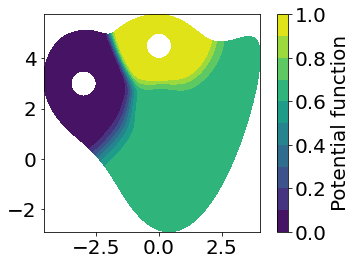

In [ ]:
# find the mesh points lying on the Dirichlet boundary \partial A \cup \partial B
NAind,Aind = find_ABbdry_pts(pts,xa,ya,ra,h0) # find mesh points on \partial A
NBind,Bind = find_ABbdry_pts(pts,xb,yb,rb,h0) # find mesh points on \partial B

def fpot(pts):
    return face(pts,par)

# find the committor
q = FEM_committor_solver(pts,tri,Aind,Bind,fpot,beta)
# visualize the committor
plt.tricontourf(pts[:,0], pts[:,1],tri,q,np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]))
plt.colorbar(label="Potential function", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})
plt.savefig('face_committor.pdf')


In [ ]:

def trajectory_probability_density(pts,tri,fpot,beta,q):
    Npts = np.size(pts,axis=0)
    Ntri = np.size(tri,axis=0)

    mu = np.zeros((Ntri,1))
    for j in range(Ntri):
        ind = tri[j,:]
        verts = pts[ind,:]
        vmid = np.reshape(np.sum(verts,axis=0)/3,(1,2))
        mu[j,:] = np.exp(-beta *fpot(vmid))

    # map reactive current on vertices
    mu_verts = np.zeros((Npts,1))
    tcount = np.zeros((Npts,1)) # the number of triangles adjacent to each vertex
    for j in range(Ntri):
        indt = np.array(tri[j,:])[:,None]    
        mu_verts[indt] = mu_verts[indt] + mu[j] # adds mu taken from center of each triangle to each vertice of the triangle
        tcount[indt] = tcount[indt] + 1   # adds a tri. to the count
    mu_verts = mu_verts/tcount # dividing to make it an average of neighboring triangles
    return mu_verts

# find the reactive current and the transition rate
Rcurrent, Rrate = reactive_current_and_transition_rate(pts,tri,fpot,beta,q)
density = trajectory_probability_density(pts, tri, fpot, beta, q)
Rdensity = density * q * (1-q)
print("Transition rate = ",Rrate)

NameError: name 'trajectory_probability_density' is not defined

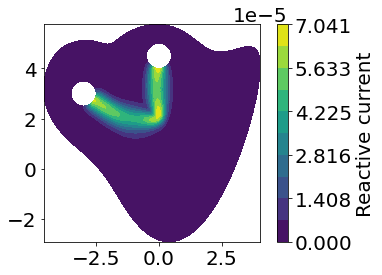

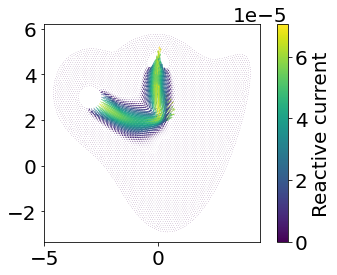

In [ ]:
# visualize the reactive current
# find the absolute value of the reactive current
ARcurrent = np.linalg.norm(Rcurrent,axis = 1)
ARCmax = np.amax(ARcurrent)
plt.tricontourf(pts[:,0], pts[:,1],tri,ARcurrent,np.linspace(0,ARCmax,11))
plt.colorbar(label="Reactive current", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})
plt.savefig('face_rcurrent.pdf')
plt.show()

RDmax = np.amax(Rdensity)
plt.tricontourf(pts[:,0], pts[:,1],tri,Rdensity,np.linspace(0,RDmax,11))
plt.colorbar(label="Reactive prob. density", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})
plt.savefig('face_rdensity.pdf')
plt.show()

plt.quiver(pts[:,0],pts[:,1],Rcurrent[:,0],Rcurrent[:,1],ARcurrent)
plt.colorbar(label="Reactive current", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})
plt.savefig('face_rcurrent_dir.pdf')

In [ ]:
# save the mesh point, the committor, and the reactive current
TPTdata = np.concatenate((pts,np.reshape(q,(Npts,1)),Rcurrent),axis = 1)
with open('face_TPTdata.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(TPTdata)